In [54]:
import tensorflow as tf
from tensorflow.keras import layers
import os
import numpy as np
import time
import matplotlib.pyplot as plt
import cv2

# Prepare the Dataset
### 15747 images (64,64,3)



In [55]:
dataset_dir = "./cats"

dataset = []
for each in os.listdir(dataset_dir):
    image = cv2.imread(os.path.join(dataset_dir, each))
    if type(image) != type(None):
        dataset.append(image)

dataset = np.array(dataset)
print(dataset.shape)

(15747, 64, 64, 3)


In [56]:
dataset.min(), dataset.max()

(0, 255)

In [57]:
dataset = (dataset - 127.5)/127.5    # Normalize the images to [-1, 1]
dataset.min(), dataset.max()

(-1.0, 1.0)

In [58]:
# Batch and shuffle the data
BATCH_SIZE = 256
BUFFER_SIZE = 15747

train_dataset = tf.data.Dataset.from_tensor_slices(dataset).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(train_dataset)

<BatchDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float64, name=None)>


# Create the Model


## Generator 


In [59]:
def generator_model():
    model = tf.keras.Sequential()
    
    model.add(layers.Dense(4*4*1024, input_shape=(100,)))
    model.add(layers.Reshape((4, 4, 1024)))
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(filters=512, kernel_size=(5,5), strides=(2,2), padding='same',
            kernel_initializer=tf.initializers.truncated_normal(stddev=0.02)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(filters=256, kernel_size=(5,5), strides=(2,2), padding='same',
             kernel_initializer=tf.initializers.truncated_normal(stddev=0.02)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(filters=128, kernel_size=(5,5), strides=(2,2), padding='same',
             kernel_initializer=tf.initializers.truncated_normal(stddev=0.02)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    

    model.add(layers.Conv2DTranspose(filters=64, kernel_size=(5,5), strides=(2,2), padding='same',
             kernel_initializer=tf.initializers.truncated_normal(stddev=0.02)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(filters=3, kernel_size=(5,5), strides=(1,1), padding='same',
             kernel_initializer=tf.initializers.truncated_normal(stddev=0.02),
             activation='tanh'))
    # output (64,64,3)

    return model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(
[[[[-3.6795562e-04 -3.4004089e-04 -7.2692987e-04]
   [-1.3955312e-03 -2.3484781e-05 -4.3096017e-05]
   [ 6.5135222e-04 -9.7987615e-04 -5.3929549e-04]
   ...
   [-1.9344487e-03 -2.1853119e-03  8.1353704e-04]
   [-1.0252666e-03 -5.1095354e-04 -6.5587240e-04]
   [-5.7139841e-04 -1.6149506e-04  9.9327753e-04]]

  [[-1.7216784e-04 -3.2948380e-04 -2.6131544e-04]
   [ 6.8611477e-04 -1.2956749e-04 -2.2562468e-04]
   [-4.8222486e-05 -2.3245253e-04 -5.4078724e-04]
   ...
   [-2.1379306e-03 -5.2411836e-03 -4.6161260e-04]
   [-2.3033805e-03 -1.8416224e-03 -1.2611242e-03]
   [-1.3932600e-03 -1.1884671e-03 -8.6567178e-04]]

  [[ 9.3277631e-04  2.9364545e-04 -3.3860942e-04]
   [-1.1545025e-03 -8.0498238e-04  1.4775585e-03]
   [-1.3595205e-03  6.2188553e-04 -1.5673131e-03]
   ...
   [-8.0999726e-04  7.8937638e-04  2.4508224e-03]
   [-8.9492946e-04  2.5426832e-04 -4.7554326e-04]
   [-1.4826255e-03 -3.3303776e-03 -8.1963110e-05]]

  ...

  [[ 1.3444999e-04 -1.0738567e-03  2.0075589e-03]
   [-

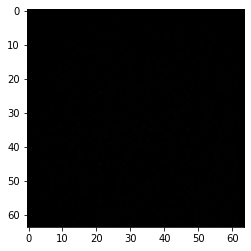

In [60]:
# Test

generator = generator_model()
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
print(generated_image)
plt.imshow(generated_image[0, :, :, :])

## Discriminator

In [61]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    
    model.add(layers.Conv2D(filters=64, kernel_size=(5,5), strides=(2,2), padding='same', input_shape=[64, 64, 3]))
    model.add(layers.BatchNormalization(epsilon = 1e-5))
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(filters=128, kernel_size=(5,5), strides=(2,2), padding='same'))
    model.add(layers.BatchNormalization(epsilon = 1e-5))
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2D(filters=256, kernel_size=(5,5), strides=(2,2), padding='same'))
    model.add(layers.BatchNormalization(epsilon = 1e-5))
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2D(filters=512, kernel_size=(5,5), strides=(1,1), padding='same'))
    model.add(layers.BatchNormalization(epsilon = 1e-5))
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2D(filters=1024, kernel_size=(5,5), strides=(2,2), padding='same'))
    model.add(layers.BatchNormalization(epsilon = 1e-5))
    model.add(layers.LeakyReLU())
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid')) # relu or sigmoid ?!
    
    return model

In [62]:
# Test

discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.4999938]], shape=(1, 1), dtype=float32)


## Model Loss

In [63]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [64]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [65]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [66]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save Checkpoints

In [67]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Training Loop

In [68]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [69]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [70]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        
        for image_batch in dataset:
            train_step(image_batch)
            
        # Produce images for the GIF as you go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                             epoch + 1,
                             seed)
        
        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
          checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        
    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                           epochs,
                           seed)

In [71]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(8, 8))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :] * 0.5 + 0.5)
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [72]:
train(train_dataset, EPOCHS)

/Users/arminzolfaghari/miniconda3/envs/tf/lib/python3.8/site-packages/keras/backend.py:5676: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_33' defined at (most recent call last):
    File "/Users/arminzolfaghari/miniconda3/envs/tf/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/arminzolfaghari/miniconda3/envs/tf/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/Users/arminzolfaghari/miniconda3/envs/tf/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/Users/arminzolfaghari/miniconda3/envs/tf/lib/python3.8/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/Users/arminzolfaghari/miniconda3/envs/tf/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 619, in start
      self.io_loop.start()
    File "/Users/arminzolfaghari/miniconda3/envs/tf/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/Users/arminzolfaghari/miniconda3/envs/tf/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/Users/arminzolfaghari/miniconda3/envs/tf/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/Users/arminzolfaghari/miniconda3/envs/tf/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/arminzolfaghari/miniconda3/envs/tf/lib/python3.8/site-packages/tornado/ioloop.py", line 688, in <lambda>
      lambda f: self._run_callback(functools.partial(callback, future))
    File "/Users/arminzolfaghari/miniconda3/envs/tf/lib/python3.8/site-packages/tornado/ioloop.py", line 741, in _run_callback
      ret = callback()
    File "/Users/arminzolfaghari/miniconda3/envs/tf/lib/python3.8/site-packages/tornado/gen.py", line 814, in inner
      self.ctx_run(self.run)
    File "/Users/arminzolfaghari/miniconda3/envs/tf/lib/python3.8/site-packages/tornado/gen.py", line 775, in run
      yielded = self.gen.send(value)
    File "/Users/arminzolfaghari/miniconda3/envs/tf/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 358, in process_one
      yield gen.maybe_future(dispatch(*args))
    File "/Users/arminzolfaghari/miniconda3/envs/tf/lib/python3.8/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/Users/arminzolfaghari/miniconda3/envs/tf/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell
      yield gen.maybe_future(handler(stream, idents, msg))
    File "/Users/arminzolfaghari/miniconda3/envs/tf/lib/python3.8/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/Users/arminzolfaghari/miniconda3/envs/tf/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 536, in execute_request
      self.do_execute(
    File "/Users/arminzolfaghari/miniconda3/envs/tf/lib/python3.8/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/Users/arminzolfaghari/miniconda3/envs/tf/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 302, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/Users/arminzolfaghari/miniconda3/envs/tf/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 539, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "/Users/arminzolfaghari/miniconda3/envs/tf/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "/Users/arminzolfaghari/miniconda3/envs/tf/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "/Users/arminzolfaghari/miniconda3/envs/tf/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/arminzolfaghari/miniconda3/envs/tf/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/arminzolfaghari/miniconda3/envs/tf/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/arminzolfaghari/miniconda3/envs/tf/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "<ipython-input-72-d152560ca122>", line 1, in <module>
      train(train_dataset, EPOCHS)
    File "<ipython-input-70-79c2efb1e284>", line 6, in train
      train_step(image_batch)
    File "<ipython-input-69-1ee37bcf02e3>", line 20, in train_step
      discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    File "/Users/arminzolfaghari/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/Users/arminzolfaghari/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/Users/arminzolfaghari/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/Users/arminzolfaghari/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/Users/arminzolfaghari/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_33'
could not find registered platform with id: 0x144e66720
	 [[{{node StatefulPartitionedCall_33}}]] [Op:__inference_train_step_15554]